# Классификатор "Хотдог или нет"

## Импорт библиотек

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Используемые версии Python и библиотек:**

In [2]:
print(f"Python {sys.version}\n")
print(f"matplotlib {matplotlib.__version__}")
print(f"numpy {np.__version__}")
print(f"PIL {PIL.__version__}")
print(f"tensorflow {tf.__version__}")

Python 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]

matplotlib 3.3.2
numpy 1.19.2
PIL 8.0.1
tensorflow 2.4.0


## Определение random_seed

Во многих функциях (например, при делении датасета на train и valid) нужно указывать seed для воспроизводимости эксперимента.

In [3]:
random_seed = 42

In [4]:
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(random_seed)
 
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(random_seed)
 
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(random_seed)
 
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(random_seed)

## Создание датасета

Необходимо скачать датасет по ссылке и сохранить папку dataset в одной директории с этим jupyter-ноутбуком:  
https://hotdogdetectorbucket.s3.amazonaws.com/train_dataset/dataset.zip

Папка dataset имеет следующую структуру:  
```
dataset/
    train/
        hotdog/
        nothotdog/
    test/
        hotdog/
        nothotdog/
```  
Содержимое папки train будет использоваться при обучении модели с выделением валидационной выборки. Содержимое папки test будет использоваться для итогового тестирования модели (эти данные модель не увидит при обучении).

In [5]:
import pathlib

data_train_dir = pathlib.Path("dataset/train/")
data_test_dir = pathlib.Path("dataset/test/")

In [6]:
image_train_count = len(list(data_train_dir.glob('*/*.jpg')))
print(f"Train size: {image_train_count}")

image_test_count = len(list(data_test_dir.glob('*/*.jpg')))
print(f"Test size: {image_test_count}")

Train size: 1604
Test size: 228


Пример хотдога:

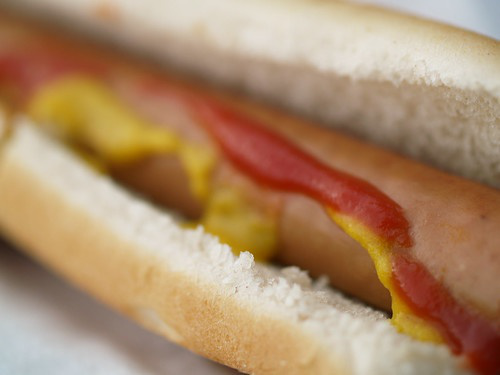

In [7]:
hotdogs = list(data_train_dir.glob('hotdog/*'))
PIL.Image.open(str(hotdogs[0]))

В качестве изображений "не хотдогов" я собрал фотографии людей, питомцев, мебели и другой еды, так как предположительно именно такие фото пользователи будут загружать для проверки классификатора. Вот один из примеров:

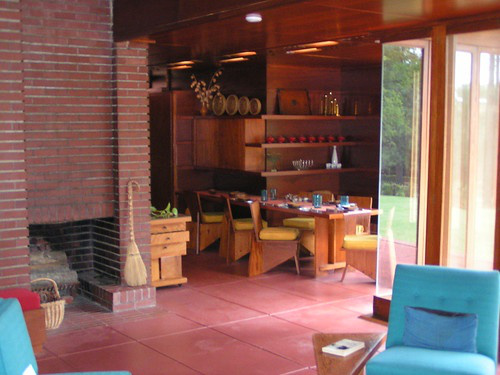

In [8]:
nothotdogs = list(data_train_dir.glob('nothotdog/*'))
PIL.Image.open(str(nothotdogs[0]))

Разделим содержимое train на обучающую и валидационную выборки и создадим тестовый датасет:

In [9]:
batch_size = 32

print("Creating train dataset:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train_dir,
    validation_split=0.2,
    subset="training",
    seed=random_seed,
    batch_size=batch_size)

print("Creating validation dataset:")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train_dir,
    validation_split=0.2,
    subset="validation",
    seed=random_seed,
    batch_size=batch_size)

print("Creating testing dataset:")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_test_dir,
    seed=random_seed,
    batch_size=batch_size)

Creating train dataset:
Found 1604 files belonging to 2 classes.
Using 1284 files for training.
Creating validation dataset:
Found 1604 files belonging to 2 classes.
Using 320 files for validation.
Creating testing dataset:
Found 228 files belonging to 2 classes.


In [10]:
class_names = train_ds.class_names
print(class_names)

['hotdog', 'nothotdog']


Примеры изображений из созданного датасета:

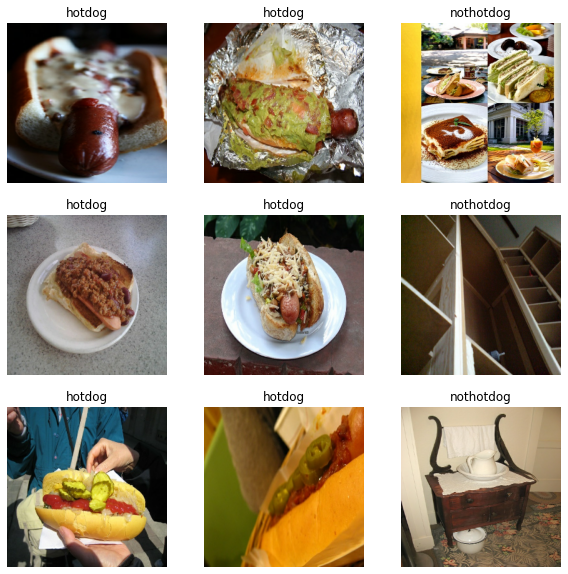

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Dataset.cache() и Dataset.prefetch()

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Создание baseline модели

In [13]:
num_classes = 2
img_height = 200
img_width = 200

baseline_model = Sequential([
    layers.experimental.preprocessing.Resizing(img_height, img_width, interpolation='bilinear', name=None),
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3), name=None),
    layers.Conv2D(16, 3, padding='same', activation='relu', name=None),
    layers.MaxPooling2D(name=None),
    layers.Conv2D(32, 3, padding='same', activation='relu', name=None),
    layers.MaxPooling2D(name=None),
    layers.Conv2D(64, 3, padding='same', activation='relu', name=None),
    layers.MaxPooling2D(name=None),
    layers.Flatten(name=None),
    layers.Dense(128, activation='relu', name=None),
    layers.Dense(num_classes, name=None)
])

In [14]:
baseline_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])

In [15]:
epochs=10
history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
41/41 [==============================] - 37s 875ms/step - loss: 1.0802 - accuracy: 0.5646 - val_loss: 0.5233 - val_accuracy: 0.7437
Epoch 2/10
41/41 [==============================] - 27s 647ms/step - loss: 0.4679 - accuracy: 0.7979 - val_loss: 0.5385 - val_accuracy: 0.7531
Epoch 3/10
41/41 [==============================] - 31s 749ms/step - loss: 0.3957 - accuracy: 0.8326 - val_loss: 0.5302 - val_accuracy: 0.7750
Epoch 4/10
41/41 [==============================] - 33s 805ms/step - loss: 0.3777 - accuracy: 0.8430 - val_loss: 0.5623 - val_accuracy: 0.7750
Epoch 5/10
41/41 [==============================] - 36s 880ms/step - loss: 0.3166 - accuracy: 0.8831 - val_loss: 0.5444 - val_accuracy: 0.7875
Epoch 6/10
41/41 [==============================] - 29s 719ms/step - loss: 0.2307 - accuracy: 0.9148 - val_loss: 0.6243 - val_accuracy: 0.7812
Epoch 7/10
41/41 [==============================] - 33s 809ms/step - loss: 0.1972 - accuracy: 0.9191 - val_loss: 1.7229 - val_accuracy: 0.6719

In [16]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        1

### Визуализация результатов обучения

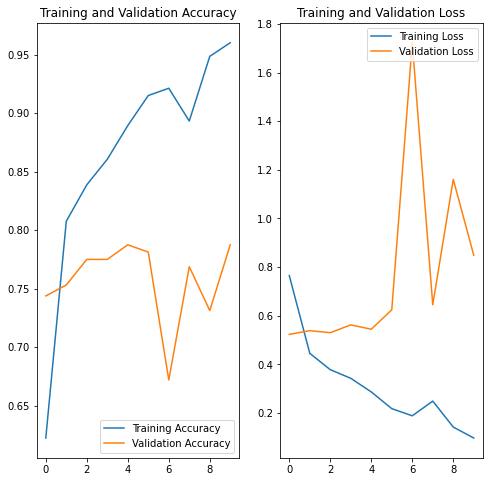

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Основной pipeline

На графике Training and Validation Accuracy выше видно, что качество работы модели на обучающих данных растет, в то время как качество на валидации остается примерно на одинаковом уровне. Также можно заметить, что разница между точностью модели на обучающих данных и точностью на валидации довольно велика. Все это - признаки **переобучения**.  
Причина переобучения заключается в небольшом размере датасета - модели не хватает данных, чтобы выявить основные закономерности.

### Увеличение данных (Data augmentation)
Сгенерируем дополнительные данные в обучающем датасете путем случайных ротаций/зумирования/переворотов исходных изображений

In [18]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                     input_shape=(img_height, 
                                                                  img_width,
                                                                  3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

Пример сгенерированных изображений:

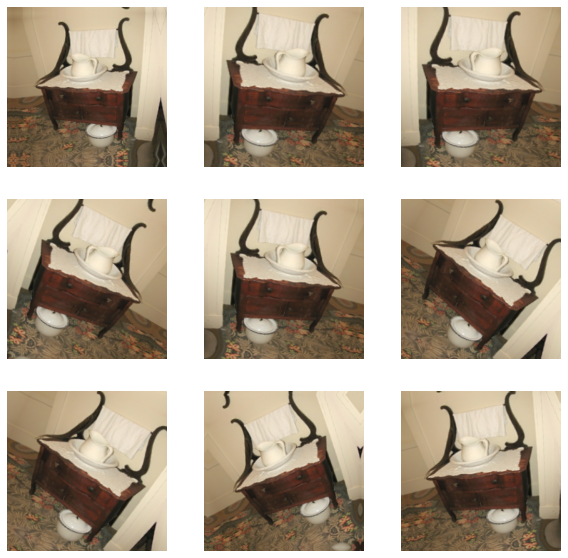

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Dropout
Другой способ уменьшить переобучение - это ввести dropout в сеть. Это форма регуляризации, которая заставляет веса в сети принимать только малые значения, что делает распределение значений веса более регулярным, и сеть может уменьшить переобучение на небольших тренировочных примерах.  
Для этого добавим слой ```layers.Dropout(0.2)``` в нейросеть.  
   
***В результате получаем следующую модель:***

In [20]:
model = Sequential([
    layers.experimental.preprocessing.Resizing(img_height, img_width, interpolation='bilinear', name=None),
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3), name=None),
    layers.Conv2D(16, 3, padding='same', activation='relu', name=None),
    layers.MaxPooling2D(name=None),
    layers.Conv2D(32, 3, padding='same', activation='relu', name=None),
    layers.MaxPooling2D(name=None),
    layers.Conv2D(64, 3, padding='same', activation='relu', name=None),
    layers.MaxPooling2D(name=None),
    layers.Dropout(0.2),
    layers.Flatten(name=None),
    layers.Dense(128, activation='relu', name=None),
    layers.Dense(num_classes, name=None)
])

### Компиляция и обучение модели

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
41/41 [==============================] - 37s 862ms/step - loss: 1.0361 - accuracy: 0.5077 - val_loss: 0.6321 - val_accuracy: 0.6594
Epoch 2/10
41/41 [==============================] - 32s 788ms/step - loss: 0.5983 - accuracy: 0.7004 - val_loss: 0.4864 - val_accuracy: 0.7844
Epoch 3/10
41/41 [==============================] - 31s 756ms/step - loss: 0.4736 - accuracy: 0.7760 - val_loss: 0.5550 - val_accuracy: 0.7688
Epoch 4/10
41/41 [==============================] - 30s 740ms/step - loss: 0.4453 - accuracy: 0.7911 - val_loss: 0.5611 - val_accuracy: 0.7812
Epoch 5/10
41/41 [==============================] - 31s 756ms/step - loss: 0.4299 - accuracy: 0.8012 - val_loss: 0.5460 - val_accuracy: 0.7781
Epoch 6/10
41/41 [==============================] - 30s 739ms/step - loss: 0.4105 - accuracy: 0.8142 - val_loss: 0.5296 - val_accuracy: 0.7750
Epoch 7/10
41/41 [==============================] - 31s 745ms/step - loss: 0.3986 - accuracy: 0.8286 - val_loss: 0.6202 - val_accuracy: 0.7625

### Визуализация результатов обучения

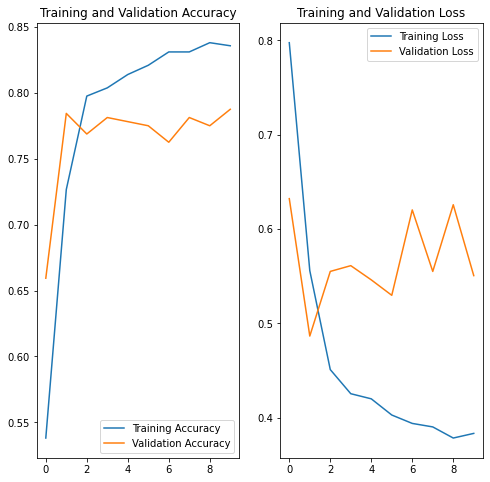

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Видно, что разрыв между обучением и валидацией уменьшился до приемлемого уровня.

## Оценка модели на тестовом датасете

Проверим модель на данных, которые она не видела при обучении:

In [24]:
print("Evaluate on test data")
results = model.evaluate(test_ds)
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

Evaluate on test data
8/8 [==============================] - 2s 170ms/step - loss: 0.5849 - accuracy: 0.7588
Test loss: 0.5848559141159058
Test accuracy: 0.7587719559669495


## Выводы

В результате мы построили сверточную нейросеть, определяющую наличие хотдога на изображении. Accuracy-метрика модели на тестовых данных - 0.75, что достаточно высоко.